In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/storage/ducpm/lung-segmentation


In [2]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
import pytorch_lightning as pl
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import transforms

from src.data import NSCLCDataset, get_common_ids, simple_collate_fn
from src.models.unet import UNet
from src.visualization import plot_batch, plot_true_vs_pred
from src.preprocess import *

In [3]:
device = "cuda:1"
from src.models.unet import UNet
net = UNet.load_from_checkpoint("models/unet-512-epoch=5-dice_coeff_val=0.940.ckpt")
net.to(device).eval();

In [4]:
transform = transforms.Compose([
    Clip(-1000, 1000),
    ToTensor(),
    Normalize(mean=[0.0], std=[1000.0]),
])

ct_ids = get_common_ids("data/raw/NSCLC-Radiomics/",
                        "data/processed/NSCLC_ground_truths/")
train_ratio = 0.7
val_ratio = 0.2
num_train_scans = int(len(ct_ids) * train_ratio)
num_val_scans = int(len(ct_ids) * val_ratio)
num_test_scans = len(ct_ids) - num_train_scans - num_val_scans
test_scans = ct_ids[num_train_scans+num_val_scans:]
print(f"train: {num_train_scans} scans, val: {num_val_scans} scans, test: {num_test_scans}")

test_ds = NSCLCDataset(metadata_path="data/processed/NSCLC-Radiomics_metadata_v2.csv",
                       ct_ids=test_scans,
                       transform=transform)
test_loader = DataLoader(test_ds, batch_size=8, collate_fn=simple_collate_fn, num_workers=4, shuffle=True, pin_memory=True)

train: 279 scans, val: 79 scans, test: 41


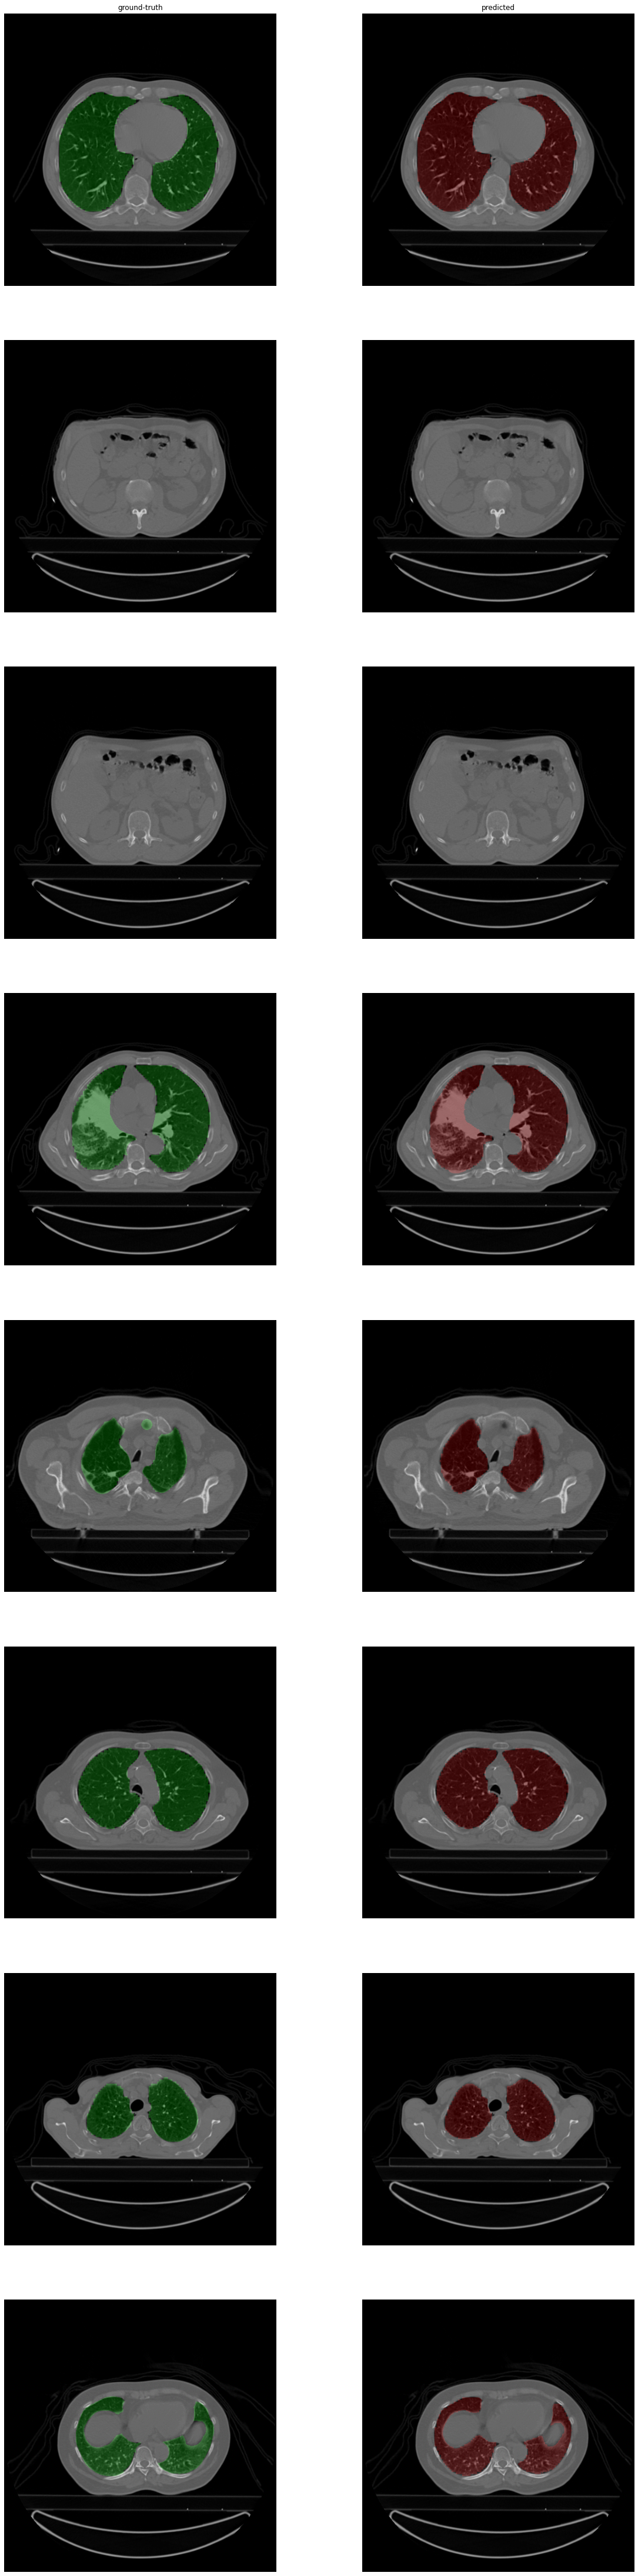

In [6]:
X_test, y_test = next(iter(test_loader))
with torch.no_grad():
    preds = net(X_test.to(device))
    pred_masks = torch.argmax(preds, dim=1)
    pred_masks = pred_masks.cpu()
plot_true_vs_pred(X_test, y_test, pred_masks,
                  mask_alpha=0.2, figsize=(20, 10))

In [ ]:
# evaluate on test set
trainer = pl.Trainer(gpus=[1])
trainer.test(net, test_dataloaders=test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [1]
